# Preprocessing and Modeling

## 1 Table of Contents

- [1 Table of Contents](#1-Table-of-Contents)
- [2 Introduction](#2-Introduction)
- [3 Setup](#3-Setup)
- [4 Tfidf and Naive Bayes with scikit-learn](#4-Tfidf-and-Naive-Bayes-with-scikit-learn)
  - [4.1 Multiclass Baseline on Six Classes](#4.1-Multiclass-Baseline-on-Six-Classes)
    - 4.1.1 Dataset Split
    - 4.1.2 Word Vectorization
    - 4.1.3 Label Encoding
    - 4.1.4 Two Naive Bayes Classifiers
    - 4.1.5 ... with Select K Best
  - [4.2 Multiclass Baseline on Four Classes](#4.2-Multiclass-Baseline-on-Four-Classes)
    - 4.2.1 Dataset Split
    - 4.2.2 Word Vectorization
    - 4.2.3 Label Encoding
    - 4.2.4 Two Naive Bayes Classifiers
    - 4.2.5 ... with Select K Best
- [5 NLP with spaCY](#5-NLP-with-spaCY)
  - [5.1 Data Preparation](#4.1-Data-Preparation)
    - 5.1.1 Dataset Selection
    - 5.1.2 Test Preprocessing
    - 5.1.3 Dataset Split
    - 5.1.4 Data Formatting
  - [5.2 Multilabel Text Categorization](#5.2-Multilabel-Text-Categorization)
    - 5.2.1 Unigram BoW
    - 5.2.2 Bigram BoW
    - 5.2.3 Model CNN
  - [5.3 Evaluations](#5.3-Evaluations)
    - 5.3.1 Classification Reports and Confusion Matrices
    - 5.3.2 Example Problem Cases
- [6 Conclusion](#6-Conclusion)

## 2 Introduction

TODO

## 3 Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_selection import SelectKBest, f_classif

import spacy
import re
from spacy.tokens import DocBin
from tqdm import tqdm
import random

#from sklearn.metrics import multilabel_confusion_matrix, hamming_loss
#from sklearn.metrics import ConfusionMatrixDisplay

import sys  
sys.path.insert(1, '../src/visualization')
import visualize

In [2]:
train_df_clean = pd.read_pickle("../data/interim/1-1_train.pkl")
test_df_clean = pd.read_pickle("../data/interim/1-1_test.pkl")
print(train_df_clean.shape, test_df_clean.shape)

(20971, 7) (20971, 7)


In [3]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20971 entries, 0 to 20970
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Computer Science      20971 non-null  int64 
 1   Physics               20971 non-null  int64 
 2   Mathematics           20971 non-null  int64 
 3   Statistics            20971 non-null  int64 
 4   Quantitative Biology  20971 non-null  int64 
 5   Quantitative Finance  20971 non-null  int64 
 6   title_abstract        20971 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


In [4]:
test_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20971 entries, 0 to 20970
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Computer Science      20971 non-null  int64 
 1   Physics               20971 non-null  int64 
 2   Mathematics           20971 non-null  int64 
 3   Statistics            20971 non-null  int64 
 4   Quantitative Biology  20971 non-null  int64 
 5   Quantitative Finance  20971 non-null  int64 
 6   title_abstract        20971 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


In [5]:
labels = train_df_clean.columns[0:6]
labels

Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')

## 4 Tfidf and Naive Bayes with scikit-learn

### 4.1 Multiclass Baseline on Six Classes

The most basic classifier for this problem will ignore the fact that there are samples that have more than one class label. Recalling from the earlier count, there should be 15927 articles with only one class label (or about 76%). As a sort of baseline, we will try to classify only the single-labeled samples, so first we select the ones with only one label.

In [6]:
train_m1c = train_df_clean[train_df_clean.iloc[:,0:6].aggregate(np.sum, axis=1) == 1]
train_m1c.shape

(15927, 7)

In [7]:
train_m1c.head(3)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...


#### 4.1.1 Dataset Split

When making a vectorizer, we also need to fit the vectorizer on the training set and keep the validation set unseen.

In [8]:
X_train_m1c, X_test_m1c, y_train_m1c, y_test_m1c = train_test_split(
    train_m1c[['title_abstract']], train_m1c[labels], test_size=0.2, random_state=42, shuffle=True)

In [9]:
print(X_train_m1c.shape, y_test_m1c.shape)

(12741, 1) (3186, 6)


In [10]:
X_train_m1c.head(3)

,title_abstract
14511,SMT Queries Decomposition and Caching in Semi-...
2241,Defining Equations of Nilpotent Orbits for Bor...
18038,Geometric features of Vessiot--Guldberg Lie al...


#### 4.1.2 Word Vectorization

For the word vectorization, we will use [`sklearn.feature_extraction.text.TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This will remove accents and normalize the words, lowercase the words, extract n-grams, and tokenize them, and it produces a TF-IDF feature matrix.

The parameters of the vectorizer could be adjusted if desired. It was mentioned that the 'english' stopword list provided by `sklearn` has its weaknesses, so a different approach could be taken for dealing with common words. Perhaps we prefer only unigrams or only bigrams, or maybe the document frequency parameters could be stricter.

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    strip_accents='unicode', # remove accents and normalize char
    lowercase=True, # lower before tokenizing
    stop_words='english', # uses provided stopword list
    min_df=2, # num of docs a term must be in
    ngram_range=(1,2) # unigrams and bigrams
)

time_start = time.time()
tfidf_X_train_m1c = tfidf_vectorizer.fit_transform(X_train_m1c.title_abstract)
tfidf_X_test_m1c = tfidf_vectorizer.transform(X_test_m1c.title_abstract)
time_end = time.time()
time_elapsed = time_end - time_start
print("Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): {} sec".format(time_elapsed))

Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): 4.401345252990723 sec


In [12]:
tfidf_vectorizer.get_feature_names_out()

array(['00', '000', '000 000', ..., 'μm', 'π_1', 'π_1 semistability'],
      dtype=object)

In [13]:
tfidf_X_train_m1c.shape

(12741, 134066)

#### 4.1.3 Label Encoding

The class labels are represented by the binary 1 marked in the corresponding label column. This may not be so friendly with classifiers, so the labels will be converted simply to the numbers \[0,5\].

In [14]:
y_train_m1c.head(3)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
14511,1,0,0,0,0,0
2241,0,0,1,0,0,0
18038,0,1,0,0,0,0


In [15]:
y_train_m1c_i = np.where(y_train_m1c)[1]
y_test_m1c_i = np.where(y_test_m1c)[1]

In [16]:
i = 0
for l in labels:
    print(i, l)
    i += 1

0 Computer Science
1 Physics
2 Mathematics
3 Statistics
4 Quantitative Biology
5 Quantitative Finance


In [17]:
pd.Series(y_train_m1c_i).value_counts()

1    4083
0    3950
2    2880
3    1301
4     358
5     169
dtype: int64

We can quickly check that the indices correspond to the correct labels.

3950 articles tagged with Computer Science
4083 articles tagged with Physics
2880 articles tagged with Mathematics
1301 articles tagged with Statistics
358 articles tagged with Quantitative Biology
169 articles tagged with Quantitative Finance


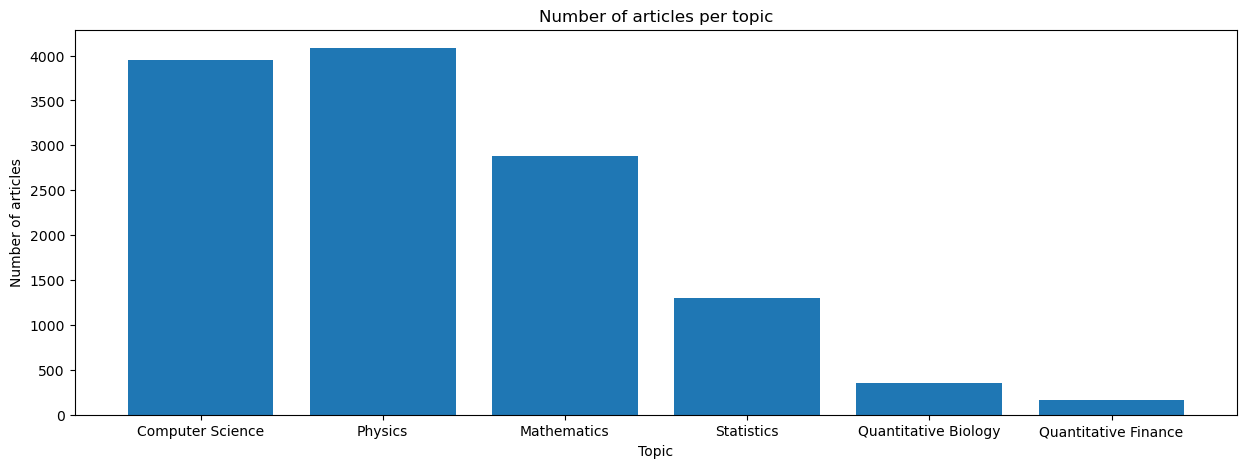

In [18]:
visualize.plot_topic_labels(labels, visualize.count_labels(labels, y_train_m1c))

#### 4.1.4 Two Naive Bayes Classifiers

Two Naive Bayes classifiers, out-of-the-box, with `balanced_accuracy_score` and macro `f1_score` will be used. These metrics were chosen because our dataset is imbalanced.

In [19]:
baccs = {}
f1_macro = {}

In the documentation for [`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB), the description mentions that it is meant for discrete features, but that it may work for tf-idf in practice. Here we will make a quick baseline for the single-labeled articles.

In [20]:
def get_bacc_macf1(clf, X_train, X_test, y_train, y_test, label_names, clf_name='', want_print=True):
    """
    Given a classifier and train and test sets, this function will return the balanced accuracy score
    and macro f1-score for the dataset.
    
    clf : Accepts a classifier that can call fit() on the X_train and y_train and return a y_pred using
          predict() on the X_test.
    X_train : Training features.
    X_test : Testing features.
    y_train : Training response variables.
    y_test : Testing response variables.
    label_names : Names of the topic labels.
    clf_name : Name of the classifier, used for print.
    want_print : This will print the classification report if True.
    """
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    
    if want_print:
        print(clf_name)
        print(metrics.classification_report(y_test, pred, target_names=label_names))
    return (metrics.balanced_accuracy_score(y_test, pred),
           metrics.f1_score(y_test, pred, average='macro'))

In [21]:
baccs['MultinomialNB_1_6'], f1_macro['MultinomialNB_1_6'] = get_bacc_macf1(
    MultinomialNB(),
    tfidf_X_train_m1c, tfidf_X_test_m1c, y_train_m1c_i, y_test_m1c_i,
    labels, 'Multiclass MultinomialNB for 6 classes'
)

Multiclass MultinomialNB for 6 classes
                      precision    recall  f1-score   support

    Computer Science       0.64      0.96      0.77       960
             Physics       0.90      0.94      0.92      1037
         Mathematics       0.94      0.83      0.88       730
          Statistics       1.00      0.01      0.02       335
Quantitative Biology       0.00      0.00      0.00        84
Quantitative Finance       0.00      0.00      0.00        40

            accuracy                           0.79      3186
           macro avg       0.58      0.46      0.43      3186
        weighted avg       0.81      0.79      0.73      3186



C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We receive warnings because we have a lot of labels that were not predicted correctly. This can be illustrated more clearly with a Confusion Matrix.

In [22]:
def plot_confusion_matrix(confusion_matrix, display_labels=None, title=""):
    """
    Plots the confusion matrix with a few formatting adjustments.
    
    confusion_matrix : An ndarray representing a confusion matrix, which should be compatible with sklearn.
    display_labels : The names of the labels used for plotting.
    title : The title to assign to the plot.
    """
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix,
        display_labels=display_labels,
        )
    _ = disp.plot(cmap=plt.cm.Blues)
    _ = plt.title(title)
    _ = plt.xticks(rotation=90)
    _ = plt.show()

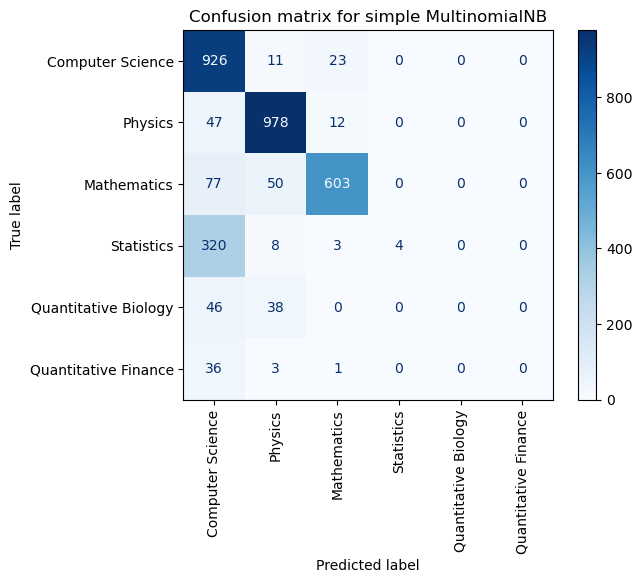

In [23]:
model = MultinomialNB()
model.fit(tfidf_X_train_m1c, y_train_m1c_i)

plot_confusion_matrix(metrics.confusion_matrix(y_test_m1c_i, model.predict(tfidf_X_test_m1c)), display_labels=labels,
                     title="Confusion matrix for simple MultinomialNB")

Evidently, the class imbalance is a big problem with this classifier. 'Quantitative Biology' and 'Quantitative Finance' are never even predicted.

There is another Naive Bayes classifier, the [`ComplementNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB), which is better-suited for imbalanced datasets.

In [24]:
baccs['ComplementNB_1_6'], f1_macro['ComplementNB_1_6'] = get_bacc_macf1(
    ComplementNB(),
    tfidf_X_train_m1c, tfidf_X_test_m1c, y_train_m1c_i, y_test_m1c_i,
    labels, 'Multiclass ComplementNB for 6 classes'
)

Multiclass ComplementNB for 6 classes
                      precision    recall  f1-score   support

    Computer Science       0.70      0.92      0.80       960
             Physics       0.91      0.95      0.93      1037
         Mathematics       0.88      0.89      0.88       730
          Statistics       0.89      0.24      0.38       335
Quantitative Biology       0.00      0.00      0.00        84
Quantitative Finance       0.87      0.33      0.47        40

            accuracy                           0.82      3186
           macro avg       0.71      0.55      0.58      3186
        weighted avg       0.81      0.82      0.79      3186



Although it is a little better, the minority classes are still not predicted well.

#### 4.1.5 ... with Select K Best

One optimization that can be considered is feature selection. Our feature space is very large, with 133,746 inputs, which can be time-consuming and strenuous. We can reduce it by using [`sklearn.feature_selection.SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html). There are different score functions that may be explored, but here, we will use `f_classif` and just check if this has any impact on the prediction.

In [25]:
selector = SelectKBest(f_classif, k=min(20000, tfidf_X_train_m1c.shape[1]))
selector.fit(tfidf_X_train_m1c, y_train_m1c_i)
X_train_m1ck = selector.transform(tfidf_X_train_m1c)
X_test_m1ck = selector.transform(tfidf_X_test_m1c)

In [26]:
X_train_m1ck.shape

(12741, 20000)

In [27]:
baccs['MultinomialNB_1_6ck'], f1_macro['MultinomialNB_1_6ck'] = get_bacc_macf1(
    MultinomialNB(),
    X_train_m1ck, X_test_m1ck, y_train_m1c_i, y_test_m1c_i,
    labels, 'Multiclass MultinomialNB for 6 classes with choose K-best'
)

Multiclass MultinomialNB for 6 classes with choose K-best
                      precision    recall  f1-score   support

    Computer Science       0.65      0.95      0.77       960
             Physics       0.91      0.93      0.92      1037
         Mathematics       0.91      0.86      0.88       730
          Statistics       0.90      0.08      0.14       335
Quantitative Biology       0.00      0.00      0.00        84
Quantitative Finance       0.00      0.00      0.00        40

            accuracy                           0.79      3186
           macro avg       0.56      0.47      0.45      3186
        weighted avg       0.79      0.79      0.75      3186



C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
baccs['ComplementNB_1_6ck'], f1_macro['ComplementNB_1_6ck'] = get_bacc_macf1(
    ComplementNB(),
    X_train_m1ck, X_test_m1ck, y_train_m1c_i, y_test_m1c_i,
    labels, 'Multiclass ComplementNB for 6 classes with choose K-best'
)

Multiclass ComplementNB for 6 classes with choose K-best
                      precision    recall  f1-score   support

    Computer Science       0.74      0.90      0.81       960
             Physics       0.91      0.94      0.93      1037
         Mathematics       0.86      0.90      0.88       730
          Statistics       0.86      0.36      0.50       335
Quantitative Biology       0.58      0.17      0.26        84
Quantitative Finance       0.83      0.60      0.70        40

            accuracy                           0.83      3186
           macro avg       0.80      0.64      0.68      3186
        weighted avg       0.83      0.83      0.82      3186



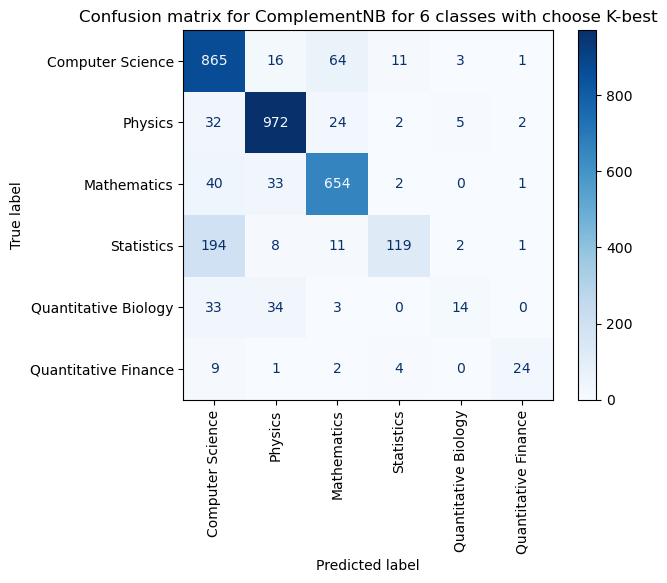

In [29]:
model = ComplementNB()
model.fit(X_train_m1ck, y_train_m1c_i)

plot_confusion_matrix(metrics.confusion_matrix(y_test_m1c_i,model.predict(X_test_m1ck)),
                     display_labels=labels,
                     title="Confusion matrix for ComplementNB for 6 classes with choose K-best")

After reducing it to 20000 features, it is nice to see that they also produce slight improvements over training on the whole tfidf vector.

### 4.2 Multiclass Baseline on Four Classes

In this little experiment, the 'Quantitative Biology' and 'Quantitative Finance' labels will be dropped. Alternative category balance methods include aggregating them as 'Other' categories or resampling the datasets. At the moment, we will not pursue either of these because they can result in a loss of data or they don't contribute new information, but they will be kept in mind.

In [30]:
# Refresh
train_m1c.head(3)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,title_abstract
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...


In [31]:
train_m1c_b = train_m1c[(train_m1c['Quantitative Biology'] == 0) & (train_m1c['Quantitative Finance'] == 0)]
train_m1c_b = train_m1c_b.drop(
    columns=['Quantitative Biology', 'Quantitative Finance'])
print(train_m1c_b.shape)
train_m1c_b.head(3)

(15276, 5)


,Computer Science,Physics,Mathematics,Statistics,title_abstract
0,1,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,1,0,0,0,Rotation Invariance Neural Network Rotation i...
2,0,0,1,0,Spherical polyharmonics and Poisson kernels fo...


In [32]:
# removal should result in 15927 = 15276 + 442 qbio + 209 qfin
train_m1c_b.shape[0] + ((train_m1c['Quantitative Biology'] == 1) | (train_m1c['Quantitative Finance'] == 1)).sum()

15927

#### 4.2.1 Dataset Split

In [33]:
labels_b = labels[:4]
X_train_m1c_b, X_test_m1c_b, y_train_m1c_b, y_test_m1c_b = train_test_split(
    train_m1c_b[['title_abstract']], train_m1c_b[labels_b],
    test_size=0.2, random_state=42, shuffle=True)

#### 4.2.2 Word Vectorization

In [34]:
tfidf_vectorizer_b = TfidfVectorizer(
    strip_accents='unicode', # remove accents and normalize char
    lowercase=True, # lower before tokenizing
    stop_words='english', # uses provided stopword list
    min_df=2, # num of docs a term must be in
    ngram_range=(1,2) # unigrams and bigrams
)

time_start = time.time()
tfidf_X_train_m1c_b = tfidf_vectorizer_b.fit_transform(X_train_m1c_b.title_abstract)
tfidf_X_test_m1c_b = tfidf_vectorizer_b.transform(X_test_m1c_b.title_abstract)
time_end = time.time()
time_elapsed = time_end - time_start
print("Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): {} sec".format(time_elapsed))

Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): 4.54784083366394 sec


#### 4.2.3 Label Encoding

Same as before.

0 Computer Science
1 Physics
2 Mathematics
3 Statistics
1    4110
0    3912
2    2865
3    1333
dtype: int64
3912 articles tagged with Computer Science
4110 articles tagged with Physics
2865 articles tagged with Mathematics
1333 articles tagged with Statistics


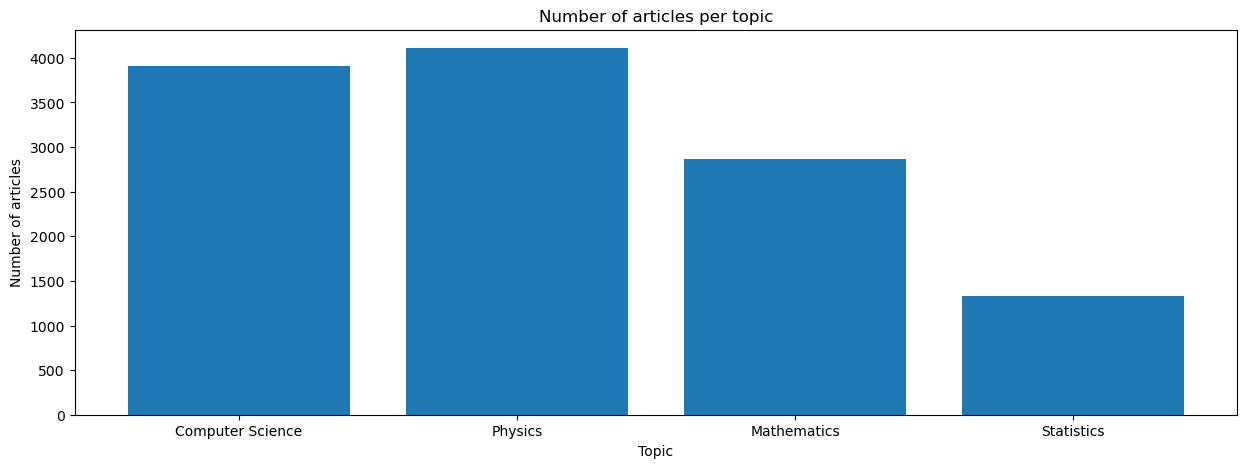

In [35]:
y_train_m1c_bi = np.where(y_train_m1c_b)[1]
y_test_m1c_bi = np.where(y_test_m1c_b)[1]

i = 0
for l in labels_b:
    print(i, l)
    i += 1

print(pd.Series(y_train_m1c_bi).value_counts())
visualize.plot_topic_labels(labels_b, visualize.count_labels(labels_b, y_train_m1c_b))

#### 4.2.4 Two Naive Bayes Classifiers

In [36]:
baccs['MultinomialNB_1_4'], f1_macro['MultinomialNB_1_4'] = get_bacc_macf1(
    MultinomialNB(),
    tfidf_X_train_m1c_b, tfidf_X_test_m1c_b, y_train_m1c_bi, y_test_m1c_bi,
    labels_b, 'Multiclass MultinomialNB for 4 classes'
)

Multiclass MultinomialNB for 4 classes
                  precision    recall  f1-score   support

Computer Science       0.71      0.97      0.82       998
         Physics       0.93      0.96      0.94      1010
     Mathematics       0.96      0.83      0.89       745
      Statistics       1.00      0.01      0.02       303

        accuracy                           0.84      3056
       macro avg       0.90      0.69      0.67      3056
    weighted avg       0.87      0.84      0.80      3056



In [37]:
baccs['ComplementNB_1_4'], f1_macro['ComplementNB_1_4'] = get_bacc_macf1(
    ComplementNB(),
    tfidf_X_train_m1c_b, tfidf_X_test_m1c_b, y_train_m1c_bi, y_test_m1c_bi,
    labels_b, 'Multiclass ComplementNB for 4 classes'
)

Multiclass ComplementNB for 4 classes
                  precision    recall  f1-score   support

Computer Science       0.76      0.94      0.84       998
         Physics       0.94      0.95      0.94      1010
     Mathematics       0.92      0.90      0.91       745
      Statistics       0.93      0.25      0.39       303

        accuracy                           0.86      3056
       macro avg       0.89      0.76      0.77      3056
    weighted avg       0.88      0.86      0.85      3056



In [38]:
from sklearn.pipeline import Pipeline

pipeline_cnb = Pipeline(
    [
        ("vect", TfidfVectorizer(strip_accents='unicode', lowercase=True, stop_words='english')),
        ("clf", ComplementNB())
    ]
)

param_grid_cnb = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 2, 5, 10),
    "vect__ngram_range": ((1,1), (1,2)),
    "vect__norm": ('l1', 'l2')
}

In [39]:
from sklearn.model_selection import RandomizedSearchCV

# random_search = RandomizedSearchCV(
#     estimator=pipeline_cnb,
#     param_distributions=param_grid_cnb,
#     n_iter=30,
#     random_state=23,
#     n_jobs=2,
#     verbose=2,
# )

In [40]:
# time_start = time.time()
# random_search.fit(X_train_m1c_b.title_abstract, y_train_m1c_bi)
# time_end = time.time()
# time_elapsed = time_end - time_start
# print("Time elapsed for ComplementNB pipeline: {} sec".format(time_elapsed))

In [41]:
# random_search.best_estimator_

Our `best_estimator_` had a score of 0.8650 with the following parameters:
```
Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.2, min_df=5, ngram_range=(1, 2),
                                 stop_words='english',
                                 strip_accents='unicode')),
                ('clf', ComplementNB())])
```

In [42]:
# random_search.best_score_

#### 4.2.5 ... with Select K Best

For this set, I am using the `TfidfVectorizer` parameters selected by the `RandomizedSearchCV`.

In [43]:
tfidf_vectorizer_b = TfidfVectorizer(
    strip_accents='unicode', # remove accents and normalize char
    lowercase=True, # lower before tokenizing
    stop_words='english', # uses provided stopword list
    max_df=0.2, # ignoring words that have a higher doc freq than this threshold
    min_df=5, # num of docs a term must be in
    ngram_range=(1,2) # unigrams and bigrams
)

time_start = time.time()
tfidf_X_train_m1c_b = tfidf_vectorizer_b.fit_transform(X_train_m1c_b.title_abstract)
tfidf_X_test_m1c_b = tfidf_vectorizer_b.transform(X_test_m1c_b.title_abstract)
time_end = time.time()
time_elapsed = time_end - time_start
print("Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): {} sec".format(time_elapsed))

Time elapsed for TfidfVectorizer fit_transform(train) and transform(test): 4.123650312423706 sec


In [44]:
selector_b = SelectKBest(f_classif, k=min(20000, tfidf_X_train_m1c_b.shape[1]))
selector_b.fit(tfidf_X_train_m1c_b, y_train_m1c_bi)
X_train_m1ck_b = selector_b.transform(tfidf_X_train_m1c_b)
X_test_m1ck_b = selector_b.transform(tfidf_X_test_m1c_b)

In [45]:
baccs['MultinomialNB_1_4ck'], f1_macro['MultinomialNB_1_4ck'] = get_bacc_macf1(
    MultinomialNB(),
    X_train_m1ck_b, X_test_m1ck_b, y_train_m1c_bi, y_test_m1c_bi,
    labels_b, 'Multiclass MultinomialNB for 4 classes with choose K-best'
)

Multiclass MultinomialNB for 4 classes with choose K-best
                  precision    recall  f1-score   support

Computer Science       0.75      0.94      0.84       998
         Physics       0.95      0.94      0.95      1010
     Mathematics       0.91      0.90      0.90       745
      Statistics       0.91      0.20      0.33       303

        accuracy                           0.86      3056
       macro avg       0.88      0.75      0.75      3056
    weighted avg       0.87      0.86      0.84      3056



In [46]:
baccs['ComplementNB_1_4ck'], f1_macro['ComplementNB_1_4ck'] = get_bacc_macf1(
    ComplementNB(),
    X_train_m1ck_b, X_test_m1ck_b, y_train_m1c_bi, y_test_m1c_bi,
    labels_b, 'Multiclass ComplementNB for 4 classes with choose K-best'
)

Multiclass ComplementNB for 4 classes with choose K-best
                  precision    recall  f1-score   support

Computer Science       0.80      0.91      0.85       998
         Physics       0.95      0.94      0.94      1010
     Mathematics       0.88      0.93      0.90       745
      Statistics       0.84      0.39      0.53       303

        accuracy                           0.87      3056
       macro avg       0.87      0.79      0.81      3056
    weighted avg       0.87      0.87      0.86      3056



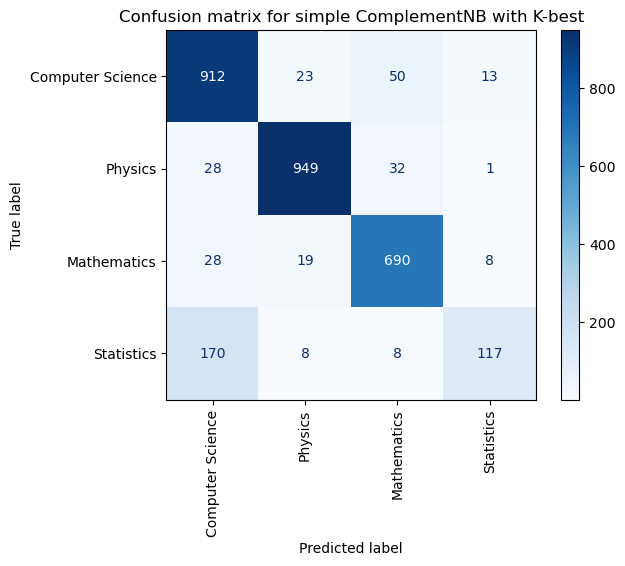

In [47]:
model = ComplementNB()
model.fit(X_train_m1ck_b, y_train_m1c_bi)

plot_confusion_matrix(metrics.confusion_matrix(y_test_m1c_bi, model.predict(X_test_m1ck_b)),
                      display_labels=labels[:4],
                      title="Confusion matrix for simple ComplementNB with K-best")

It may be redundant to mention again at this point, but the dataset imbalance remains a problem for these models.

### 4.3 Evaluations

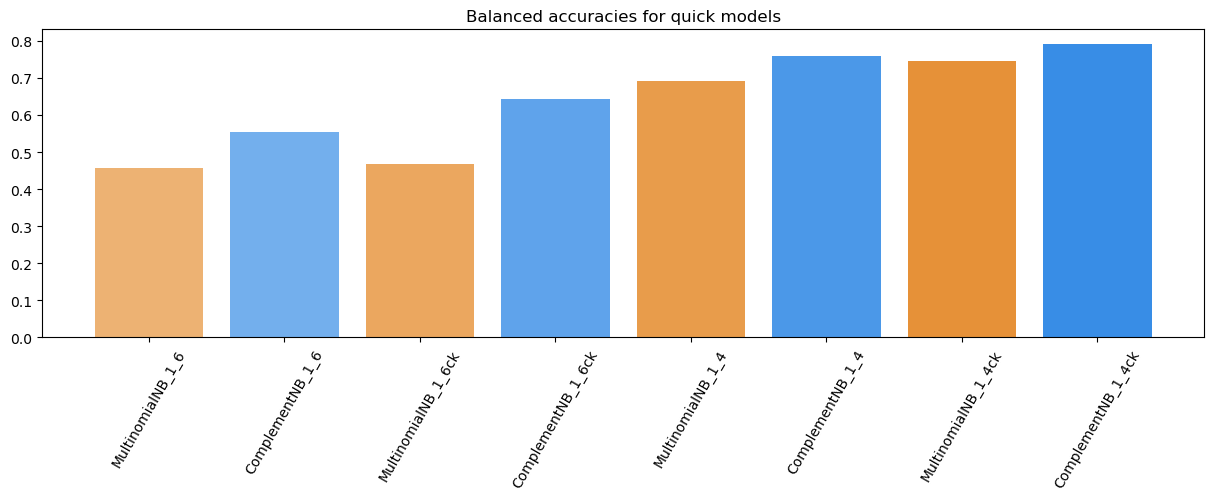

In [48]:
color_list = ['#edb273', '#73afed', '#eba75f', '#5fa3eb', '#e89c4b', '#4b98e8', '#e69138', '#388de6']
_ = plt.figure(figsize=(15,4))
_ = plt.title("Balanced accuracies for quick models")
_ = plt.xticks(rotation=60)
_ = plt.bar(baccs.keys(), baccs.values(), color=color_list)

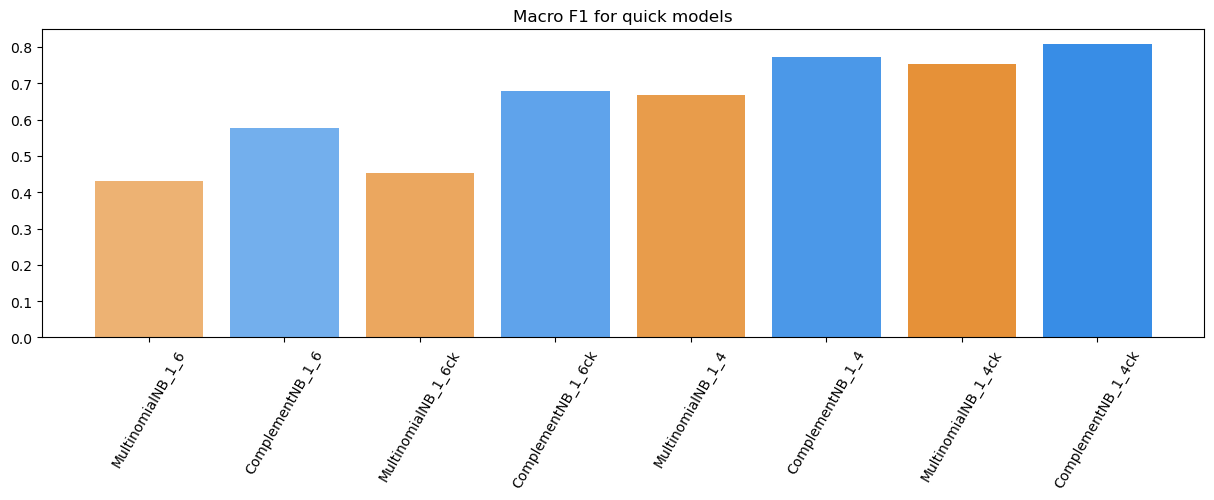

In [49]:
_ = plt.figure(figsize=(15,4))
_ = plt.title("Macro F1 for quick models")
_ = plt.xticks(rotation=60)
_ = plt.bar(f1_macro.keys(), f1_macro.values(), color=color_list)

In [50]:
(pd.DataFrame([pd.Series(baccs), pd.Series(f1_macro)]).T).rename(columns={0:'balanced_acc',1:'macro_f1'})

,balanced_acc,macro_f1
MultinomialNB_1_6,0.457609,0.431818
ComplementNB_1_6,0.554567,0.577787
MultinomialNB_1_6ck,0.468871,0.452213
ComplementNB_1_6ck,0.642690,0.678909
MultinomialNB_1_4,0.692791,0.668685
ComplementNB_1_4,0.758471,0.771491
MultinomialNB_1_4ck,0.745031,0.753119
ComplementNB_1_4ck,0.791436,0.808253


TODO

## 5 NLP with spaCY

### 5.1 Data Preparation

#### 5.1.1 Dataset Selection

In this experiment, multiple labels will be retained, but we will again drop the two underrepresented classes, and we will use [spaCy](https://spacy.io/). To begin, the dataset needs to be split into three parts. The naming convention appears to use 'train', 'dev', and 'test', where 'train' is the training data, 'dev' is used for evaluation during training, and 'test' is the final evaluation set.

In [51]:
mul_df = train_df_clean.loc[:,['title_abstract'] + list(labels[:4])]
mul_df.head(3)

,title_abstract,Computer Science,Physics,Mathematics,Statistics
0,Reconstructing Subject-Specific Effect Maps P...,1,0,0,0
1,Rotation Invariance Neural Network Rotation i...,1,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0


In [52]:
mul_df.shape

(20971, 5)

At this point, `mul_df` is the dataset of all 20971 rows of 'train.csv', but we want to exclude samples that are tagged with only 'Quantitative Biology', only 'Quantitative Finance', or exactly both of those. Since the two columns were already excluded, then the remaining rows that we do not want to keep are simply the "unlabeled" ones, for which the label binary sequence would be `0000`. In other words, their label columns would sum up to 0.

In [53]:
mul_df = mul_df[mul_df[labels[:4]].aggregate(np.sum, axis=1) != 0]
mul_df.shape

(20316, 5)

This reduced our dataset by 655 (20971-20316=655), and we can check that this was done correctly by verifying that it matches the size of the original DataFrame when excluding every row that is not exactly one of \[`000010`, `000001`, `000011`\].

In [54]:
train_df_clean[
    (train_df_clean.loc[:,['Quantitative Biology', 'Quantitative Finance']].aggregate(np.sum, axis=1) >= 1) &
    (train_df_clean.loc[:,labels[:4]].aggregate(np.sum, axis=1) == 0)
].shape

(655, 7)

#### 5.1.2 Text Preprocessing

SpaCy has many components in its `nlp` pipeline, so there are a lot of decisions that could be made in what to include, exclude, or disable ([link](https://spacy.io/usage/processing-pipelines#disabling)). In an effort to be a bit more efficient and because this is meant to be a preprocessing step, a handful of components will be excluded. The "en_core_web_sm" has 'tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', and 'ner' by default, but for now we will exclude 'parser' and 'ner'.

There are a few specially-formatted words in the texts, such as "amyloid-\$\\\beta\\$", which are not split properly by this tokenizer, so we have to manually remove the special characters with regex. This can be seen at the bottom of our function.

In [55]:
nlp = spacy.load("en_core_web_sm", exclude=['parser', 'ner'])
nlp.Defaults.stop_words.add("i.e.")

def spacy_preprocess(text, lower=True, rmv_stop=True, rmv_num=True, make_lemma=True, rmv_punc=True):
    """
    Preprocesses the text using spacy's English pipeline "en_core_web_sm", but excludes the parser and ner components.
    Various flags are included to control how much preprocessing should take place. Special characters are always removed.
    
    text : Raw text to preprocess.
    lower : Flag that determines whether to lowercase everything.
    rmv_stop : Flag to remove stopwords.
    rmv_num : Flag to remove numbers.
    make_lemma : Flag to lemmatize the tokens.
    rmv_punc : Flag to remove punctuation.
    """
    # Convert text to Doc of tokens
    doc = nlp(text.lower() if lower else text)
    tokens = [token for token in doc]
    
    # Remove stopwords
    if rmv_stop:
        tokens = [token for token in tokens if not token.is_stop]
    # Remove numbers
    if rmv_num:
        tokens = [token for token in tokens if not (token.like_num or token.is_currency)]
    # Remove punctuation
    if rmv_punc:
        tokens = [token for token in tokens if not token.is_punct]
    # Remove empty tokens
    tokens = [token for token in tokens if (token.text.strip() != "") and not token.is_space]
    
    if make_lemma:
        text = " ".join([token.lemma_ for token in tokens])
    else:
        text = " ".join([token.text for token in tokens])

    # Remove special
    text = re.sub(r"[^a-zA-Z\']", " ", text)
    
    return text

In [56]:
# Takes 3-4 minutes
#time_start = time.time()
#mul_df['text'] = mul_df['title_abstract'].apply(spacy_preprocess)
#time_end = time.time()
#time_elapsed = time_end - time_start
#print("Time elapsed for spacy preprocessing: {} sec".format(time_elapsed))

#mul_df.head(3)

In [57]:
# Saved so that we don't have to keep preprocessing it
#mul_df.to_pickle("../data/interim/2-0_mul_sp.pkl")

In [58]:
mul_df = pd.read_pickle("../data/interim/2-0_mul_sp.pkl")
mul_df.head(3)

,title_abstract,Computer Science,Physics,Mathematics,Statistics,text
0,Reconstructing Subject-Specific Effect Maps P...,1,0,0,0,reconstruct subject specific effect map predic...
1,Rotation Invariance Neural Network Rotation i...,1,0,0,0,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,0,0,1,0,spherical polyharmonic poisson kernel polyharm...


In [59]:
mul_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20316 entries, 0 to 20970
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title_abstract    20316 non-null  object
 1   Computer Science  20316 non-null  int64 
 2   Physics           20316 non-null  int64 
 3   Mathematics       20316 non-null  int64 
 4   Statistics        20316 non-null  int64 
 5   text              20316 non-null  object
dtypes: int64(4), object(2)
memory usage: 1.1+ MB


The first batch of cleaning and preprocessing done with NLTK and gensim took 10-15 minutes. Sklearn's `TfidfVectorizer` on 70% of the data took about 5 seconds. SpaCy preprocessing on the training data took 3-4 minutes. Of course, they are all doing different things, but it cannot be denied that spaCy's was very fast when taking into account all the extra work it was doing. The `TfidfVectorizer` has the least detailed processes in the sense that it does not also take into account semantics; it has some cleaning and preprocessing, and it provides a numerical representation of the unigrams and bigrams. It's simple, and hence, it is very fast. On the other hand, the NLTK with gensim preprocessing and spaCy preprocessing were more comparable, but NLTK was 2-5 times slower. However, setting up spaCy took more research and digging around, whereas NLTK and gensim were pretty much thrown together out-of-the-box and produced fairly clean text. I feel that my `spacy_preprocessing` could be made or done in a more sophisticated way, but it may be sufficient for now.

In [60]:
mul_df['text'].sample(1).values

array(['discrete wavelet transform base algorithm recognition qrs complex paper propose application discrete wavelet transform dwt detect qrs ecg characterize recurrent wave sequence p qrs t wave electrocardiogram ecg signal wavelet transform provide localization time frequency preprocessing stage dwt remove baseline wander ecg signal performance algorithm qrs detection evaluate standard mit bih massachusetts institute technology beth israel hospital arrhythmia database average qrs complex detection rate achieve'],
      dtype=object)

#### 5.1.3 Dataset Split

Now we can shuffle and split the dataset into the three sets:
 - `mul_train_df`: training data, consisting of 75% of the data
 - `mul_dev_df`: testing data for training, consisting of 15% of the data (or 60% of the remaining data)
 - `mul_test_df`: final testing data, consisting of 10% of the data (or 40% of the remaining data)

In [61]:
n_75 = int(mul_df.shape[0] * .75)
n_15 = int(mul_df.shape[0] * .15)
n_10 = int(mul_df.shape[0] * .10) + 1
print("{} = {} + {} + {} = {}".format(mul_df.shape[0], n_75, n_15, n_10, (n_75 + n_15 + n_10)))

20316 = 15237 + 3047 + 2032 = 20316


In [62]:
# Shuffle
mul_df_shuffled = mul_df.sample(frac=1, random_state=23)
# train 75
mul_train_df = mul_df_shuffled.iloc[:n_75]
# test 15
mul_dev_df = mul_df_shuffled.iloc[n_75:(n_75+n_15)]
# val 10
mul_test_df = mul_df_shuffled.iloc[(n_75+n_15):]

# Verify
print("{} + {} + {} = {}".format(mul_train_df.shape[0],
                                mul_dev_df.shape[0],
                                mul_test_df.shape[0],
                                (mul_train_df.shape[0] + mul_dev_df.shape[0] + mul_test_df.shape[0])
                                )
     )

15237 + 3047 + 2032 = 20316


In [63]:
mul_train_df.head(3)

,title_abstract,Computer Science,Physics,Mathematics,Statistics,text
2608,Towards a More Reliable Privacy-preserving Rec...,1,0,0,0,reliable privacy preserve recommender system p...
17505,Yamabe Solitons on three-dimensional normal al...,0,0,1,0,yamabe soliton dimensional normal paracontact ...
5962,Quantum torus algebras and B(C) type Toda syst...,0,1,1,0,quantum torus algebras b c type toda system pa...


#### 5.1.4 Data Formatting

Our datasets are still stored as DataFrames, so we will convert them into a binary file using spaCy's [DocBin](https://spacy.io/api/docbin). We also need to set up the labels properly.

In [64]:
def make_tuples_list(df, text_col_name, label_names):
    """
    Extracts the desired columns from the dataframe and returns the data as a list of tuples.
    
    df : The dataframe to extract from.
    text_col_name : The name of the column that contains the text information.
    label_names : A list of the names of the columns that indicate whether the sample belongs to this category.
    Potential issue - (KeyError) text_col_name and label_names must exist in the DataFrame as columns.
    """
    return list(zip(
        df.loc[:,text_col_name].to_list(),
        df.loc[:,label_names].to_dict(orient='records')))

In [65]:
def convert_to_DocBin(data, label_names, outfile):
    """
    Converts a list of tuples to a DocBin file.
    
    data : A list of tuples, which must contain the text and the category labels as a dictionary of values 0 or 1.
    label_names : The names of the categories.
    outfile : The output filename.
    """
    nlp = spacy.load("en_core_web_sm", exclude=['parser', 'ner'])
    db = DocBin()
    print("Processing data into docs for DocBin")
    for doc, context in tqdm(nlp.pipe(data, as_tuples=True)):
        for ln in label_names:
            doc.cats[ln] = context[ln]
        db.add(doc)
    db.to_disk(outfile)
    print("Added to {}".format(outfile))

In [66]:
# This takes about 1.5-2 min
#convert_to_DocBin(make_tuples_list(mul_train_df, 'text', labels_b), labels_b, "../data/processed/2-0-0-train.spacy")
#convert_to_DocBin(make_tuples_list(mul_dev_df, 'text', labels_b), labels_b, "../data/processed/2-0-1-dev.spacy")
#convert_to_DocBin(make_tuples_list(mul_test_df, 'text', labels_b), labels_b, "../data/processed/2-0-2-test.spacy")

### 5.2 Multilabel Text Categorization

#### 5.2.1 Unigram BoW

In [67]:
!python -m spacy evaluate ../models/2-0-spacy_model_bow/model-best ../data/processed/2-0-2-test.spacy --output ../models/2-0-spacy_model_bow/model-best/metrics_best_model.json

[i] Using CPU

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   94.65 
SPEED                 437929


=========================== Textcat F (per label) ===========================

                       P       R       F
Computer Science   86.73   87.31   87.01
Physics            92.86   83.53   87.94
Mathematics        85.93   82.08   83.96
Statistics         75.72   79.23   77.44


======================== Textcat ROC AUC (per label) ========================

                   ROC AUC
Computer Science      0.94
Physics               0.97
Mathematics           0.96
Statistics            0.92

[+] Saved results to
..\models\2-0-spacy_model_bow\model-best\metrics_best_model.json


**Adjustments to the unigram BoW**: A few alternative parameters were checked as well, but their models did not yield different enough results or valuable enough improvements. Generally, the only way for the model to attain better scores was to decrease the learning rate (ie. `*0.1`), but naturally this increased the time of training, and the improvement was very small so it's not really worth the time. For brevity of the notebook, these tests are left out. The process was fairly straightforward because spaCY allows you to override an existing config file parameters via the command line, so I just used the original unigram bow config file with different variable assignments. To do this programmatically through Python script, check this [page](https://spacy.io/usage/training#api-train).

#### 5.2.2 Bigram BoW

In [68]:
!python -m spacy evaluate ../models/2-0-spacy_model_bow2/model-best ../data/processed/2-0-2-test.spacy --output ../models/2-0-spacy_model_bow2/metrics_best_model.json

[i] Using CPU

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   94.33 
SPEED                 369682


=========================== Textcat F (per label) ===========================

                       P       R       F
Computer Science   83.99   88.20   86.04
Physics            92.52   83.53   87.79
Mathematics        86.23   80.82   83.44
Statistics         73.14   77.42   75.22


======================== Textcat ROC AUC (per label) ========================

                   ROC AUC
Computer Science      0.94
Physics               0.97
Mathematics           0.95
Statistics            0.92

[+] Saved results to
..\models\2-0-spacy_model_bow2\metrics_best_model.json


The bigram BoW model performed similarly but slightly worse than the unigram one.

#### 5.2.3 Model CNN

In [69]:
!python -m spacy evaluate ../models/2-0-spacy_model_cnn/model-best ../data/processed/2-0-2-test.spacy --output ../models/2-0-spacy_model_cnn/metrics_best_model.json

[i] Using CPU

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   94.84 
SPEED                 36979 


=========================== Textcat F (per label) ===========================

                       P       R       F
Computer Science   87.76   81.40   84.46
Physics            88.75   84.51   86.58
Mathematics        87.85   79.03   83.21
Statistics         66.15   85.89   74.74


======================== Textcat ROC AUC (per label) ========================

                   ROC AUC
Computer Science      0.94
Physics               0.97
Mathematics           0.95
Statistics            0.93

[+] Saved results to
..\models\2-0-spacy_model_cnn\metrics_best_model.json


The CNN model yielded similar results, but training the CNN takes a lot longer, so it is not really worth the time and resources for this application.

### 5.3 Evaluations

#### 5.3.1 Classification Reports and Confusion Matrices

In [70]:
def convert_DocBin_to_dict(infile):
    """
    Converts the spaCY DocBin file back into a list of text and a categories dictionary.
    
    infile : The file to load from.
    """
    nlp = spacy.load("en_core_web_sm", exclude=['parser', 'ner'])
    db = DocBin().from_disk(infile)
    print("Processing DocBin into dict")
    samples = []
    for doc in tqdm(db.get_docs(nlp.vocab)):
        sample = {
            "text": doc.text,
            "cats": doc.cats
        }
        samples.append(sample)
    return samples

In [71]:
# Load eval DocBin
# Totally unnecessary in this notebook because we have it saved here
samples = convert_DocBin_to_dict("../data/processed/2-0-2-test.spacy")

Processing DocBin into dict


2032it [00:00, 3623.50it/s]


In [72]:
def spacy_predict(model_path, X):
    """
    Loads a model to predict categories. Returns the predictions in a list.
    
    model_path : Path to the model.
    X : Text input to categorize.
    """
    nlp = spacy.load(model_path)
    y_pred = []
    for x in X:
        doc = nlp(x)
        y_pred.append(doc.cats)
    return y_pred

In [73]:
y_pred = spacy_predict("../models/2-0-spacy_model_bow/model-best", [sample['text'] for sample in samples])

In [74]:
y_pred[0]

{'Computer Science': 0.38637566566467285,
 'Physics': 0.21485790610313416,
 'Mathematics': 0.23983894288539886,
 'Statistics': 0.18380902707576752}

In [75]:
samples[0]

{'text': 'preprint d j  vu faq brief overview arxiv history describe current state arxiv practice technical sociological commentary originally appear embo journal oct intend update comment late      use preprint biologist lack thereof interest practitioner discipline base largely keynote presentation give asapbio inaugural meeting feb respond follow question',
 'cats': {'Computer Science': 1,
  'Physics': 1,
  'Mathematics': 0,
  'Statistics': 0}}

The [scorer](https://spacy.io/api/scorer#score_cats)'s threshold for our best_model here was 0.5, which can be verified in the model's 'config.cfg', so in the above situation, none of the categories would have been assigned 1. The documentation for the scorer states that the threshold's default value is 0.5 for multilabel, so we will retain that as our default value.

In [76]:
def prob_to_bin(y_pred, threshold=0.5, min_one_true=False):
    """
    Interprets the category probabilities to a 0 or 1 depending on whether the probability exceeds a threshold.
    Set min_one_true to force at least min_one_true number of categories assigned to 1, which will be the category
    with the highest probability.
    
    y_pred : List of predicted probabilities.
    threshold : Determines whether to assign the category 0 or 1. The predicted value must be greater than or equal
        to the threshold to be assigned 1.
    min_one_true : Flag that indicates whether to force the category corresponding to the highest predicted value to
        always be 1.
    """
    y_pred_bin = []
    for pred in y_pred:
        pred_bin = {}
        counter = 0
        big_key, big_prob = '', 0
        for key, value in pred.items():
            if value >= threshold:
                pred_bin[key] = 1
                counter += 1
            else:
                pred_bin[key] = 0
            if min_one_true:
                # take note of big
                if value >= big_prob:
                    big_key = key
                    big_prob = value
        if min_one_true and counter == 0:
            pred_bin[big_key] = 1
        y_pred_bin.append(pred_bin)
    return y_pred_bin

In [77]:
y_pred_bin_50 = prob_to_bin(y_pred, threshold=0.5)

In [78]:
y_pred_bin_50[0]

{'Computer Science': 0, 'Physics': 0, 'Mathematics': 0, 'Statistics': 0}

In [79]:
y_pred_bin_50[1]

{'Computer Science': 0, 'Physics': 1, 'Mathematics': 0, 'Statistics': 0}

In [80]:
def dict_to_sparse(y, want_print=True):
    y_sparse = []
    for y_i in y:
        y_sparse.append(list(y_i.values()))
    if want_print:
        print(len(y_sparse))
        print(y_sparse[0])
        print(y_sparse[1])
    return y_sparse

In [81]:
y_pred_sparse = dict_to_sparse(y_pred_bin_50)

2032
[0, 0, 0, 0]
[0, 1, 0, 0]


In [82]:
y_true_sparse = dict_to_sparse([sample['cats'] for sample in samples])

2032
[1, 1, 0, 0]
[0, 1, 0, 0]


In [83]:
multi_confusion = metrics.multilabel_confusion_matrix(y_true_sparse, y_pred_sparse)

In [84]:
multi_confusion

array([[[1014,  120],
        [ 114,  784]],

       [[1386,   39],
        [ 100,  507]],

       [[1399,   75],
        [ 100,  458]],

       [[1410,  126],
        [ 103,  393]]], dtype=int64)

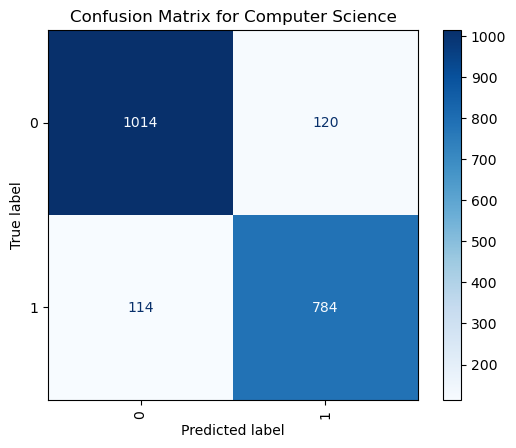

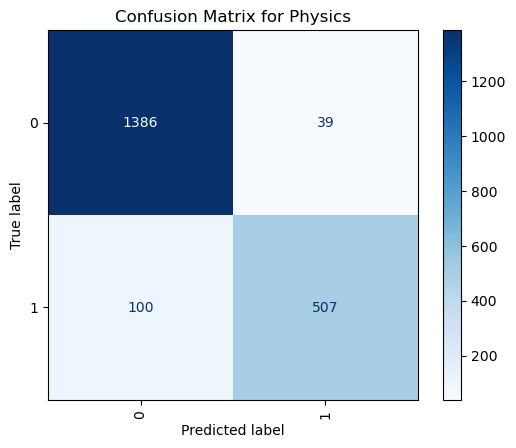

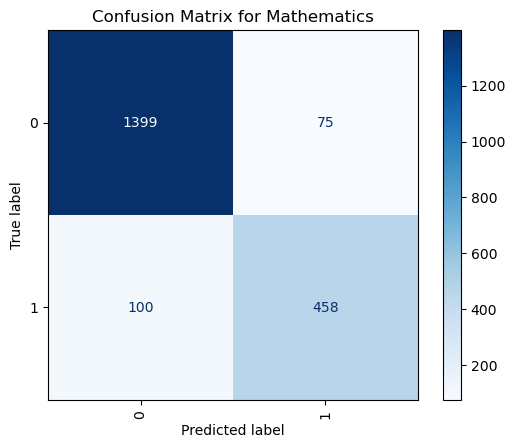

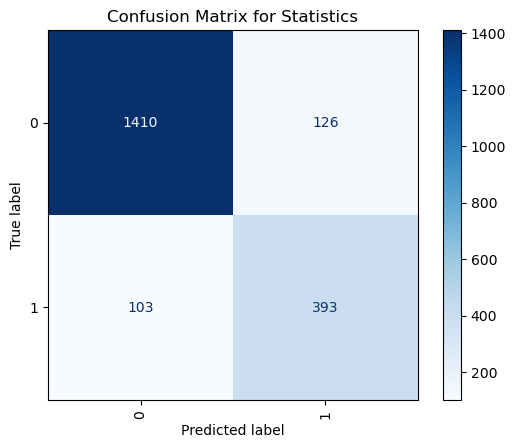

In [85]:
i = 0
for label in list(samples[0]['cats'].keys()):
    title = "Confusion Matrix for " + label
    plot_confusion_matrix(multi_confusion[i], title=title)
    i += 1

In [86]:
for thr in [0.4, 0.45, 0.5]:
    print("Threshold =", thr)
    y_pred_sparse = dict_to_sparse(prob_to_bin(y_pred, threshold=thr), want_print=False)
    print(metrics.classification_report(y_true_sparse, y_pred_sparse,
                              target_names=list(samples[0]['cats'].keys())))
    print("Hamming Loss: ", metrics.hamming_loss(y_true_sparse, y_pred_sparse), "\n")

Threshold = 0.4
                  precision    recall  f1-score   support

Computer Science       0.84      0.90      0.87       898
         Physics       0.90      0.86      0.88       607
     Mathematics       0.83      0.85      0.84       558
      Statistics       0.72      0.83      0.77       496

       micro avg       0.83      0.87      0.85      2559
       macro avg       0.82      0.86      0.84      2559
    weighted avg       0.83      0.87      0.85      2559
     samples avg       0.86      0.90      0.86      2559

Hamming Loss:  0.09977854330708662 

Threshold = 0.45
                  precision    recall  f1-score   support

Computer Science       0.86      0.89      0.87       898
         Physics       0.92      0.85      0.88       607
     Mathematics       0.85      0.83      0.84       558
      Statistics       0.74      0.82      0.78       496

       micro avg       0.84      0.85      0.85      2559
       macro avg       0.84      0.85      0.84      25

C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chian\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


I'm partial to the `threshold=0.45` because I want it to be a bit more eager to label something as true. The very first sample shows an issue with the model, which is that it may predict that there is no label at all for the sample, but the reality is that every sample has at least one label. Also I imagine that in most applications, a higher recall may be more desirable than a higher precision. For example, I would not want a search engine to give me no articles versus a few articles that are at least somewhat relevant.

What if we tried a different scorer or interpretation of the predictions returned? Since we know that there must be at least one label per sample, we can force it to return its "best" guess.

In [87]:
# Unsure if this is LEGAL, but it's a thought.
# min_true = 1 because there are no 0000, though we could add those too
# That is another thought
y_true_sparse = dict_to_sparse([sample['cats'] for sample in samples], want_print=False)
for thr in [0.4, 0.45, 0.5]:
    print("Threshold =", thr)
    y_pred_sparse = dict_to_sparse(prob_to_bin(y_pred, threshold=thr, min_one_true=True), want_print=False)
    print(metrics.classification_report(y_true_sparse, y_pred_sparse,
                              target_names=list(samples[0]['cats'].keys())))
    print("Hamming Loss: ", metrics.hamming_loss(y_true_sparse, y_pred_sparse), "\n")

Threshold = 0.4
                  precision    recall  f1-score   support

Computer Science       0.84      0.90      0.87       898
         Physics       0.90      0.86      0.88       607
     Mathematics       0.83      0.85      0.84       558
      Statistics       0.72      0.84      0.78       496

       micro avg       0.82      0.87      0.85      2559
       macro avg       0.82      0.86      0.84      2559
    weighted avg       0.83      0.87      0.85      2559
     samples avg       0.87      0.90      0.86      2559

Hamming Loss:  0.09916338582677166 

Threshold = 0.45
                  precision    recall  f1-score   support

Computer Science       0.85      0.90      0.87       898
         Physics       0.91      0.85      0.88       607
     Mathematics       0.84      0.84      0.84       558
      Statistics       0.74      0.83      0.78       496

       micro avg       0.84      0.86      0.85      2559
       macro avg       0.84      0.85      0.84      25

Their f1-scores are pretty comparable to the zero-allowed interpreter, but there are slight differences in precision, recall, and the Hamming Loss. Overall, the Hamming Loss is a little bit better with our greedy interpreter. If we care about having better recall, the greedy `threshold=0.45` is best. The greedy `threshold=0.5` also has a little bit better precision.

Let's see our confusion matrix with the greedy `0.45` threshold. This should clearly illustrate what has changed: there are more positive labels than before and fewer negative labels than before.

[[[ 994  140]
  [  92  806]]

 [[1375   50]
  [  89  518]]

 [[1388   86]
  [  90  468]]

 [[1391  145]
  [  86  410]]]


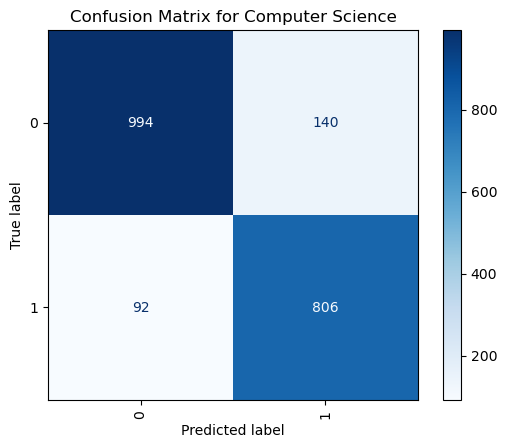

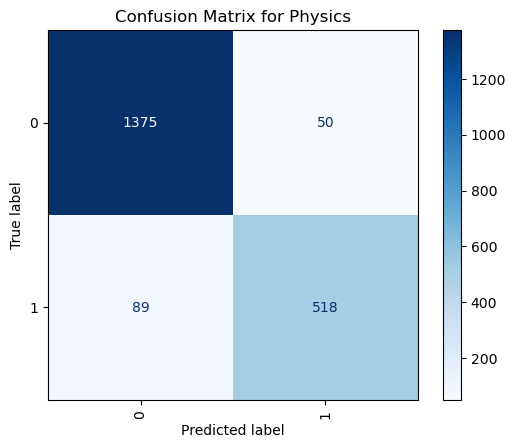

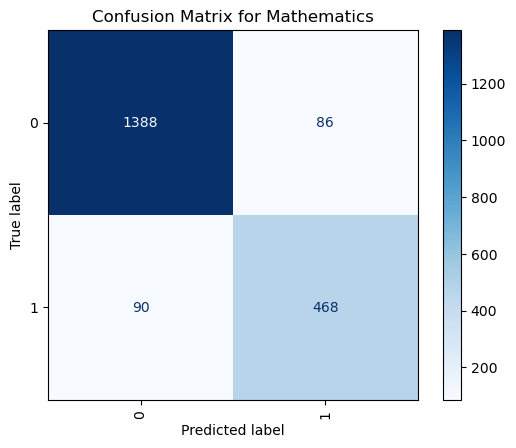

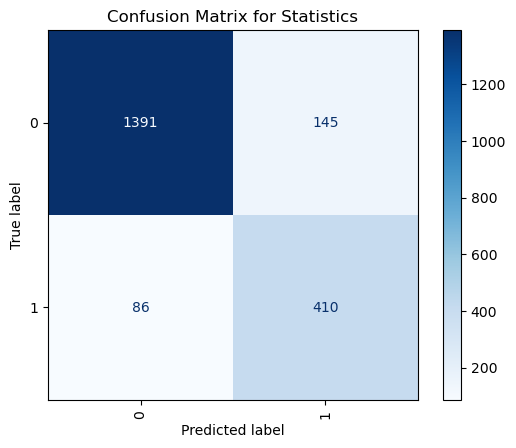

In [88]:
y_pred_sparse = dict_to_sparse(prob_to_bin(y_pred, threshold=0.45, min_one_true=1), want_print=False)
multi_confusion = metrics.multilabel_confusion_matrix(y_true_sparse, y_pred_sparse)
print(multi_confusion)
i = 0
for label in list(samples[0]['cats'].keys()):
    title = "Confusion Matrix for " + label
    plot_confusion_matrix(multi_confusion[i], title=title)
    i += 1

There are 16 possible combinations with values in `[0000,1111]` (or `[0,15]`), where the order of place values is 'Computer Science', 'Physics', 'Mathematics', and 'Statistics'.

In [89]:
def binlist4_to_int(binlist):
    """
    Converts a 4-digit binary list into an integer [0,15]. Returns -1 if the list is not of length 4.
    
    binlist : List of 0's and 1's of length 4.
    """
    if (len(binlist) == 4):
        return (binlist[0] * 2**3 + binlist[1] * 2**2 + binlist[2] * 2**1 + binlist[3])
    return -1

In [90]:
y_pred_int = [binlist4_to_int(y_pred_i) for y_pred_i in y_pred_sparse]
y_true_int = [binlist4_to_int(y_true_i) for y_true_i in y_true_sparse]

Although there are 16 possible combinations, we cannot get `0000` with the greedy interpreter, and `1111` was never predicted.

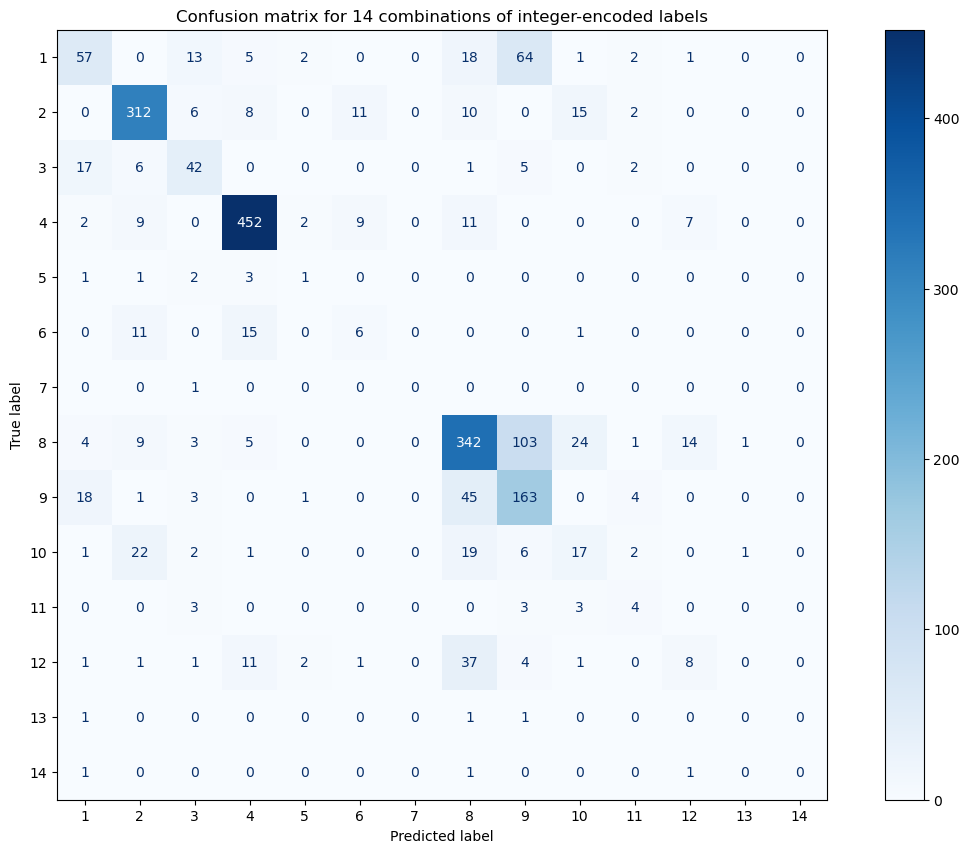

In [91]:
fig, ax = plt.subplots(figsize=(15, 10))
_ = metrics.ConfusionMatrixDisplay.from_predictions(y_true_int, y_pred_int, ax=ax, cmap=plt.cm.Blues)
_ = plt.title("Confusion matrix for 14 combinations of integer-encoded labels")

In [92]:
def int_to_cat(num):
    """
    Converts the integer value to the corresponding categories, taking some combination of CS|Ph|Ma|St.
    
    num : An integer in [0,15].
    """
    if num >= 16 | num < 0:
        return ""
    bin_string = str.format("{:04b}", num)
    return ("CS|" if bin_string[0] == '1' else "--|") \
           + ("Ph|" if bin_string[1] == '1' else "--|") \
           + ("Ma|" if bin_string[2] == '1' else "--|") \
           + ("St" if bin_string[3] == '1' else "--")

In [93]:
multicat_labels = [int_to_cat(i) for i in range(0,16)]

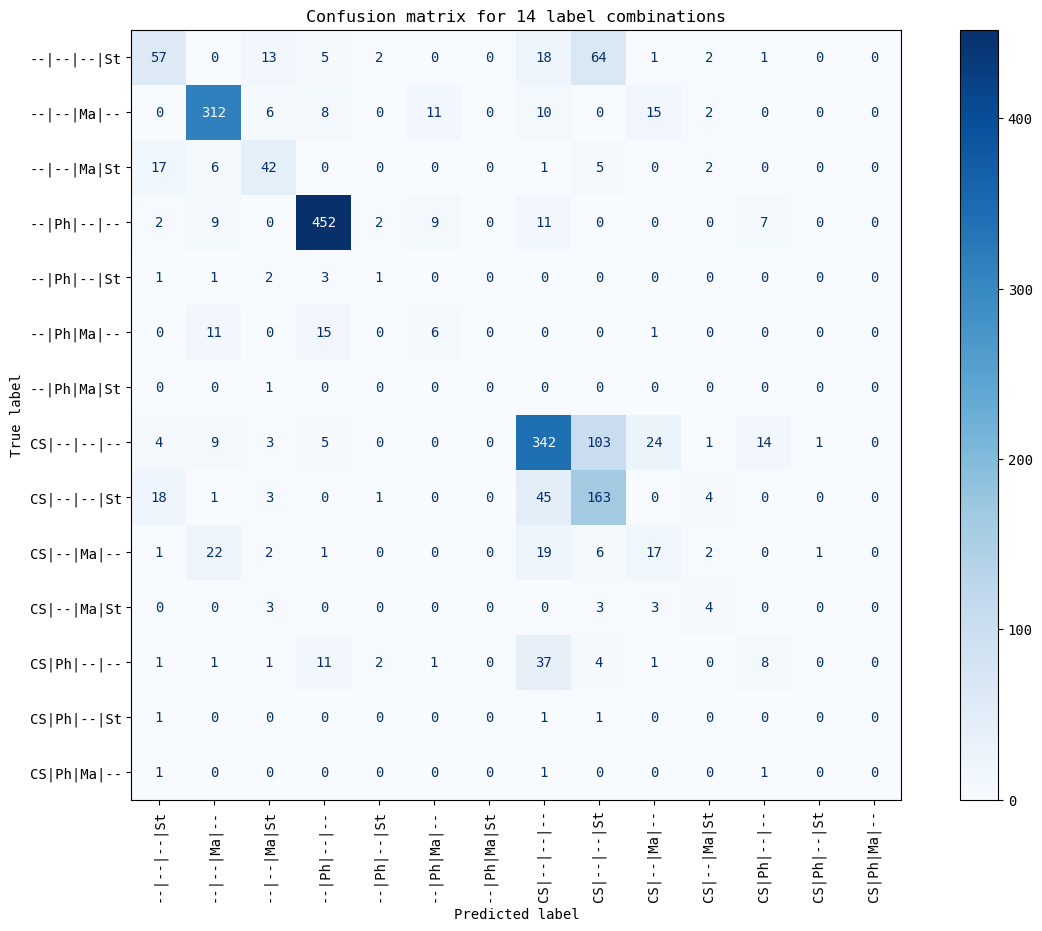

In [94]:
with plt.rc_context({'font.family': 'monospace'}):
    fig, ax = plt.subplots(figsize=(15, 10))
    cmp = metrics.ConfusionMatrixDisplay.from_predictions(y_true_int, y_pred_int,
                                            display_labels=multicat_labels[1:15],
                                            xticks_rotation='vertical',
                                            cmap=plt.cm.Blues,
                                            ax=ax)
    _ = plt.title("Confusion matrix for 14 label combinations")

The labels that stand out the most as inaccurately labeled seem to fall primarily into 'Computer Science' or 'Statistics'. Those labeled with 'Statistics' should make sense because we knew from the beginning that 'Statistics' had relatively few samples, but for 'Computer Science' to have so much inaccuracy is curious. Let's examine a few of these cases (pred->true):
 - `CS|--|--|-- -> CS|--|--|St`
 - `CS|--|--|-- -> CS|Ph|--|--`
 - `CS|--|--|St -> CS|--|--|--`
 - `CS|--|--|St -> --|--|--|St`

There are few 3-class samples in the validation set, but of these incorrect 3-class samples, there also seems to be more issues when CS is involved.

#### 5.3.2 Example Problem Cases

In [95]:
incorrectly_labeled = []
for i in range(0,len(y_pred_sparse)):
    if y_pred_sparse[i] != y_true_sparse[i]:
        incorrectly_labeled.append((i, y_pred_sparse[i], y_true_sparse[i]))

In [96]:
print("{} out of {} samples were labeled incorrectly, or {:2.2f}%."
      .format(len(incorrectly_labeled),
              len(y_true_sparse),
              (len(incorrectly_labeled) / len(y_true_sparse) * 100) ))

628 out of 2032 samples were labeled incorrectly, or 30.91%.


In [97]:
cs_pred_idx_list = []
csst_pred_idx_list = []
for i, pred, true in incorrectly_labeled:
    if (pred[0] == 1):
        # pred CS and true CS
        if(np.sum(pred[1:]) == 0):
            # pred CS only
            if (true[1] == 1) | (true[3] == 1):
                # save to list if true Ph or St
                cs_pred_idx_list.append((i, pred, true))
        if(pred[3] == 1) & (np.sum(pred[:]) == 2):
            # pred CS and St
            if (np.sum(true[:]) == 1):
                # pure 1 label
                if (true[0] == 1) | (true[3] == 1):
                    # save to list if pure CS or pure St
                    csst_pred_idx_list.append((i, pred, true))

In [98]:
def pick_cases(sample_tuples, y_pred, original_samples, n_cases=3):
    """
    Randomly selects n_cases number of cases out of a sample list sample_tuples.
    
    sample_tuples : A list of tuples in the form of (index, predicted_categories, true_categories) from which to
        randomly pick from.
    y_pred : The actual predicted category probabilities.
    original_samples : The original list of samples, stored as a dict with a 'text' key.
    n_cases : The number of random samples to select.
    
    Potential errors: Please make sure the tuple is the correct format because the components are addressed
        directly and are used for indexing. The samples also require a dictionary key named 'text'.
    """
    for i in range(0,n_cases):
        selections = random.choice(sample_tuples)
        print("idx {}: pred {}, true {}".format(selections[0], selections[1], selections[2]))
        for cat,prob in y_pred[selections[0]].items():
            print("{:16s}: {:>5.4f}".format(cat, prob))
        print(original_samples[selections[0]]['text'])
        print()

##### Case I: Predicted Computer Science only for 2-class samples with Physics and Statistics.
Examining the pure CS case, where pred=`CS|--|--|--` and true=`CS|Ph|--|St` with only 2 labels.

In [99]:
pick_cases(cs_pred_idx_list, y_pred, samples, n_cases=3)

idx 1290: pred [1, 0, 0, 0], true [0, 0, 0, 1]
Computer Science: 0.9941
Physics         : 0.0012
Mathematics     : 0.0098
Statistics      : 0.1319
multi task select learn approach solve new type  d bin packing problem paper study new type  d bin packing problem bpp number cuboid shape item bin orthogonally objective find way place item minimize surface area bin problem base fact fix sized bin real business scenario cost bin proportional surface area base previous research  d bpp surface area determine sequence spatial location orientation item new np hard combinatorial optimization problem unfixed sized bin packing propose multi task framework base select learning generate sequence orientation item pack bin simultaneously training step select learn choose loss function derive deep reinforcement learning supervise learn correspond training procedure numerical result method propose significantly outperform lego baseline substantial gain produce large scale  d bin packing order datum set 

For those samples incorrectly predicted as pure 'Computer Science', the text does look like it may heavily fall into CS because they mention words that pertain to CS. It seems like CS may show up so often because the texts talk about the tools and approaches used, so softwares and technologies come up a lot. The next highest probabilities for the labels are usually the correct second label, though these probabilities range anywhere from very small (less than 5%) to almost reaching that threshold cutoff (slightly less than 45%).

##### Case II: Predicted Computer Science and Statistics for 1-class samples.
Examining the CS+St case, where pred=`CS|--|--|St` and true=`CS|--|--|St` with only 1 label.

In [100]:
pick_cases(csst_pred_idx_list, y_pred, samples, n_cases=3)

idx 960: pred [1, 0, 0, 1], true [1, 0, 0, 0]
Computer Science: 0.9866
Physics         : 0.0047
Mathematics     : 0.0001
Statistics      : 0.5781
learn fly crash learn navigate unmanned aerial vehicle uav avoid obstacle approach use small dataset collect human expert high capacity learn algorithm tend overfit train little datum alternative use simulation gap simulation real world remain large especially perception problem reason research avoid large scale real datum fear crash paper propose bite bullet collect dataset crash build drone sole purpose crash object sample naive trajectory crash random object crash drone time create big uav crash dataset dataset capture different way uav crash use negative fly datum conjunction positive datum sample trajectory learn simple powerful policy uav navigation simple self supervise model effective navigate uav extremely cluttered environment dynamic obstacle include human supplementary video https url

idx 425: pred [1, 0, 0, 1], true [1, 0, 0, 0]

A lot of these texts seemed to relate to data science topics, such as machine learning and model optimization.

## 6 Conclusion

TODO